In [1]:
#!pip install numpy
#!pip install sklearn

In [2]:
from IPython.core.display import HTML
HTML("""
<style>
.consignes{
  font-weight: bold;
  color: #3256a8;
  background-color: #edebdf
}
</style>
""")



# TP2: Détection de menaces radar

<div class=consignes> Listez les noms des étudiants (2 au maximum) ayant participé à ce notebook dans la cellule suivante (prénom, nom, affectation).<br/>
Au moment du rendu, le notebook doit être nommé nom1_nom2_dlts_tp2.ipynb 

2 séances de TP sur ce sujet : le 18 octobre (1h30) et le 25 octobre (3h).<br> 
Deadline : 8 novembre 2023, 11h59, par mail à deepetsignal.mva@gmail.com <br> 

Pour installer les paquets nécessaires à la réalisation de ce TP vous pouvez utiliser dans le notebook 
    
```
!pip install \< nom_du_paquet \>
```
merci de regrouper toutes les installations dans la première cellule du notebook. 
Essayez de faire en sorte que votre notebook puisse se lire comme un compte rendu, évitez de laisser du code mort et prennez le temps de commenter vos observations et résultats.
    
## Mission


Vous commandez un avion de reconnaissance en mission top secrète. Malgré votre discretion et toutes les précautions prises vous dérangez et pouvez être sujet de menaces qu'il vous faut détecter pour garantir la sécurité de votre équipage et la succès de votre mission (comme elle est top secrète vous ne pouvez pas en savoir plus). 

A votre disposition un réseau d'antennes et un système d'analyse spectrale perfectionnés vous permettent d'extraire et de caractériser des signaux en provenance des radars à altitude 0 qui parsèment votre parcours. 

Un signal radar est composé d'impulsions. Le système d'analyse vous permettent de caractériser chaque impulsion reçue par un PDW (Pulse Description Word) qui contient: 

- la date de début de détection de l'impulsion (en ms)
- la largeur ou durée de l'impulsion (en ms)
- la puissance de l'impulsion (en dB / référence) 
- l'angle theta et l'angle phi décrivant la direction dans laquelle l'impulsion est détectée (en radians)
- la fréquence de l'impulsion (en Ghz)

Votre capteur n'est pas parfait et vous subissez notamment un phénomène de mitage: une certaine proportion des impulsions émises ne sont pas détectées. Cette proportion est d'autant plus grande que la puissance des impulsions est petite.  

Votre vaisseau navigue à 10 km d'altitude, avec une vitesse constante de 1000 km/h vers le nord. 

De précédentes missions ont permis de réaliser une base de données de signaux de 10 secondes. 
Chaque signal se présente sous la forme d'un fichier .npz qui contient l'ensemble des PDW reçus. 

Un signal est donc un fichier dont le nom est de la forme 'pdw_<numéro du signal>.npz'.

Cette base de données est annotée: le destin de chaque mission a permis de déclarer chaque signal comme une 'menace' ou une 'nonmenace'. 

Les signaux ont été divisés en deux ensembles indépendants: 
    
- train
- test 
 
Les annotations pour chaque ensemble sont disponibles dans le fichier labels_<train ou test>.json qui donne l'association nom de fichier -> menace ou nonmenace. 
    
    
Votre mission (si vous l'acceptez) est de choisir et d'entrainer un algorithme d'apprentissage machine à détecter les menaces sur l'ensemble 'train' et à évaluer ses performances sur l'ensemble 'test'. 

Fort de votre expérience passée, vous décidez de suivre la méthodologie suivante: 

- Visualisation et analyse des données pour trouver les paramètres les plus pertinents à utiliser 
- Sélection d'un algorithme naïf "baseline" de référence: vous définissez un premier algorithme simple et caractérisez ses performances qui serviront de point de comparaison pour qualifier l'apport d'algorithmes plus sophistiqués 
- Vous utilisez la bibliothèque sklearn et notamment ses implémentations d'algorithmes de classification binaire pour définir et entrainer sur l'ensemble 'train' un ou plusieurs algorithmes en capacité de prédire le label menance ou nonmenace de chaque signal (https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html)
- Vous qualifiez les performances de vos algorithmes en termes d'accuracy (https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html#sklearn.metrics.accuracy_score) ; vous calculez aussi les matrices de confusion (https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html#sklearn.metrics.confusion_matrix)
    
Pour ce TP nous ne cherchons pas à mettre en place des algorithmes d'apprentissage profond. Ces méthodes pourront être investiguées dans un deuxième temps.
    
 Si les résultats vous semblent décevants, souvenez vous des conseils de votre prédecesseur et mentor G. Abitbol: "toujours donner un coup de pouce à un algo de machine learning  en lui présentant les bonnes données"

Vous pouvez ouvrir un fichier de la façon suivante:

</div>    

In [1]:
import numpy as np
import sklearn as skl
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats

from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
# import Xgboost 
import xgboost as xgb

## Importation des signaux d'entrainement

In [2]:
# Import all the signals that are in the format npz
# each signal is a 2D dataframe
import os, json
directory_path = "./radars/train/"
files = os.listdir(directory_path)

with open('./radars/train_labels.json') as f: 
    dict_labels = json.load(f)

label_map={'menace':1,'nonmenace':0}
train_signals= {}
train_labels = {}
length = len(files)
i = 0 
for file in files : 
    if file.endswith(".npz") : 
        pdws = np.load(directory_path + file)
        dates = pdws['date']
        largeurs = pdws['largeur']
        frequences=pdws['frequence']
        puissances = pdws['puissance']
        theta = pdws['theta']
        phi = pdws['phi']
        signal=file.split(".")[0]
        train_signals[signal] =pd.DataFrame({"dates" : dates,"largeurs" : largeurs, "frequences": frequences,"puissances": puissances, "theta" :theta, "phi" : phi})
        
        label=int(label_map[dict_labels[signal]])
        train_labels[signal]=label


## Importation des signaux de test

In [3]:
# Importer tous les signaux au format npz
# chaque signal est un dataframe 2D
import os, json
directory_path = "./radars/test/"
files = os.listdir(directory_path)

with open('./radars/test_labels.json') as f: 
    dict_labels = json.load(f)

label_map={'menace':1,'nonmenace':0}
test_signals= {}
test_labels = {}
length = len(files)
i = 0 
for file in files : 
    if file.endswith(".npz") : 
        pdws = np.load(directory_path + file)
        dates = pdws['date']
        largeurs = pdws['largeur']
        frequences=pdws['frequence']
        puissances = pdws['puissance']
        theta = pdws['theta']
        phi = pdws['phi']
        signal=file.split(".")[0]
        test_signals[signal] =pd.DataFrame({"dates" : dates,"largeurs" : largeurs, "frequences": frequences,"puissances": puissances, "theta" :theta, "phi" : phi})
        
        label=int(label_map[dict_labels[signal]])
        test_labels[signal]=label
        

In [4]:
#sample from dataset
Signal = train_signals["pdw-122"]
# Get insights about the data 
#Sort signal by dates
Signal = Signal.sort_values(by=["dates"])
Signal

,dates,largeurs,frequences,puissances,theta,phi
0,3.071,0.035,1.630957,-131.715567,2.425446,1.857740
1,5.869,0.036,1.632938,-132.972805,2.106207,1.628599
2,6.102,0.037,1.637447,-133.212035,2.194983,1.456782
3,12.393,0.037,1.643570,-140.869643,2.316960,1.709008
4,17.051,0.037,1.631926,-154.508786,2.308359,1.562750
...,...,...,...,...,...,...
4293,9990.829,0.035,1.645159,-149.054275,-1.459170,1.625227
4294,9992.228,0.037,1.631879,-149.457733,-1.649243,1.547299
4295,9993.161,0.036,1.633771,-149.480399,-1.394940,1.755165
4296,9994.557,0.036,1.643363,-150.079297,-1.178553,1.541186


In [73]:
Label=train_labels['pdw-122']
Label

1

In [60]:
pdws_elements=np.load("./radars/train/pdw-0.npz").files
pdws_elements

['date', 'largeur', 'frequence', 'puissance', 'theta', 'phi']

# 1.Baseline Model

### 1.1.Creation de dataframes contenant les information moyennes des signaux (df_train, df_test)

In [5]:
# Créer un dataframe qui contient tous les signaux, chaque signal a été réduit
list = []
for key,value in train_signals.items() :
    signal = value
    list.append({"largeurs" : np.mean(signal["largeurs"]), "frequences": np.mean(signal["frequences"]) ,"puissances": np.mean(abs(signal["puissances"])), "target":train_labels[key]})

df_train = pd.DataFrame(list)

In [6]:
df_train.head()

,largeurs,frequences,puissances,target
0,0.292003,2.202149,151.168286,0
1,0.137017,2.996037,152.733649,0
2,0.046013,0.620546,163.891152,1
3,0.052999,2.614020,157.447361,0
4,0.100012,2.091032,160.803986,0


In [7]:
list = []
for key,value in test_dataset.items() :
    signal = value
    list.append({"largeurs" : np.mean(signal["largeurs"]), "frequences": np.mean(signal["frequences"]) ,"puissances": np.mean(abs(signal["puissances"])), "target":test_labels[key]})

df_test = pd.DataFrame(list)

NameError: name 'test_dataset' is not defined

In [ ]:
# Diviser les données d'entée et de test
X_train, X_test, y_train, y_test = df_train.drop(["target"], axis=1), df_test.drop(["target"], axis=1), df_train["target"], df_test["target"]

In [ ]:
# Redimensionner les données
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# Retransormer les données dans un dataframe
X_train = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test = pd.DataFrame(X_test_scaled, columns = X_train.columns)

### 1.2. Entraînement de la baseline

In [ ]:
!pip install xgboost

In [ ]:
names = [
    "Nearest Neighbors",
    "Linear SVM",
    "RBF SVM",
    "Gaussian Process",
    "Decision Tree",
    "Random Forest",
    "Neural Net",
    "AdaBoost",
    "Naive Bayes",
    "QDA",
]

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025, random_state=42),
    SVC(gamma=2, C=1, random_state=42),
    GaussianProcessClassifier(1.0 * RBF(1.0), random_state=42),
    DecisionTreeClassifier(max_depth=5, random_state=42),
    RandomForestClassifier(
        max_depth=5, n_estimators=10, max_features=1, random_state=42
    ),
    MLPClassifier(alpha=1, max_iter=1000, random_state=42),
    AdaBoostClassifier(random_state=42),
    GaussianNB(),
    QuadraticDiscriminantAnalysis(),
]

# itérer sur les ensembles de données
    # ensemble de données de prétraitement, divisé en formation et partie test

for name, clf in zip(names, classifiers):

        clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)
        #print the score for each classifier
        print(name," : ", score)


Nearest Neighbors  :  0.72625
Linear SVM  :  0.72375
RBF SVM  :  0.7825
Gaussian Process  :  0.7825
Decision Tree  :  0.74625
Random Forest  :  0.7675
Neural Net  :  0.75875
AdaBoost  :  0.755
Naive Bayes  :  0.70625
QDA  :  0.70375


# 2. Analyse Exploratoire de données (EDA)


## 2.1. Toujours avec les données moyennées des signaux

### Visualisation de la distribution des *valeurs moyennes* des variables selon la classe du signal

Le but de cette visualisation est de reperer à travers des graphes et des courbes les tendances et les comportements intrinsèques de chaque variables susceptible d'expliquer la menace d'un signal donné. Cependant, avant de choisir ses variables, il faut envisager à poser des hypothèses de dépendance issues de notre analyse visuelle. Pour cela, on va prendre des signaux aléatoires de chaque catégorie (menace et non menace) et visualiser la distribution de ses variables : 

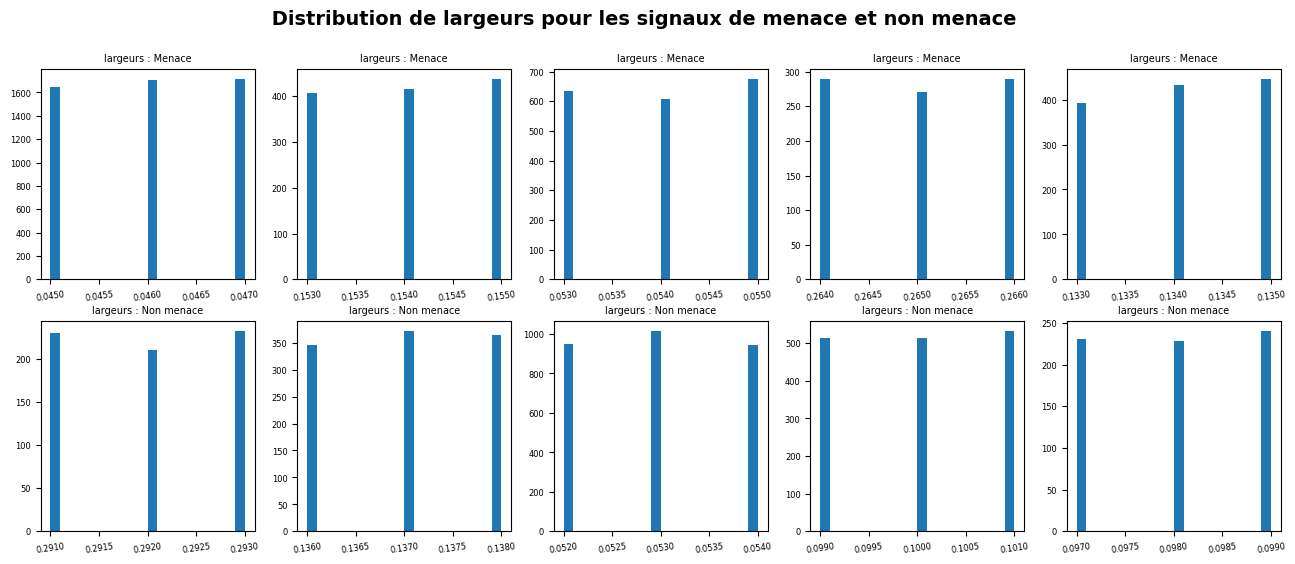

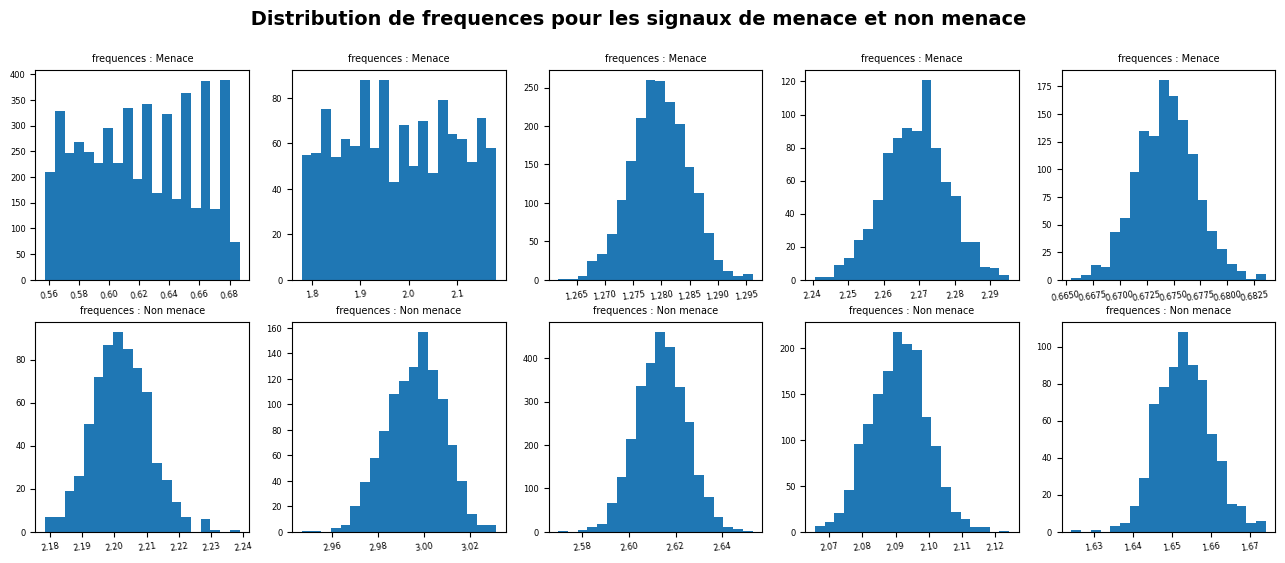

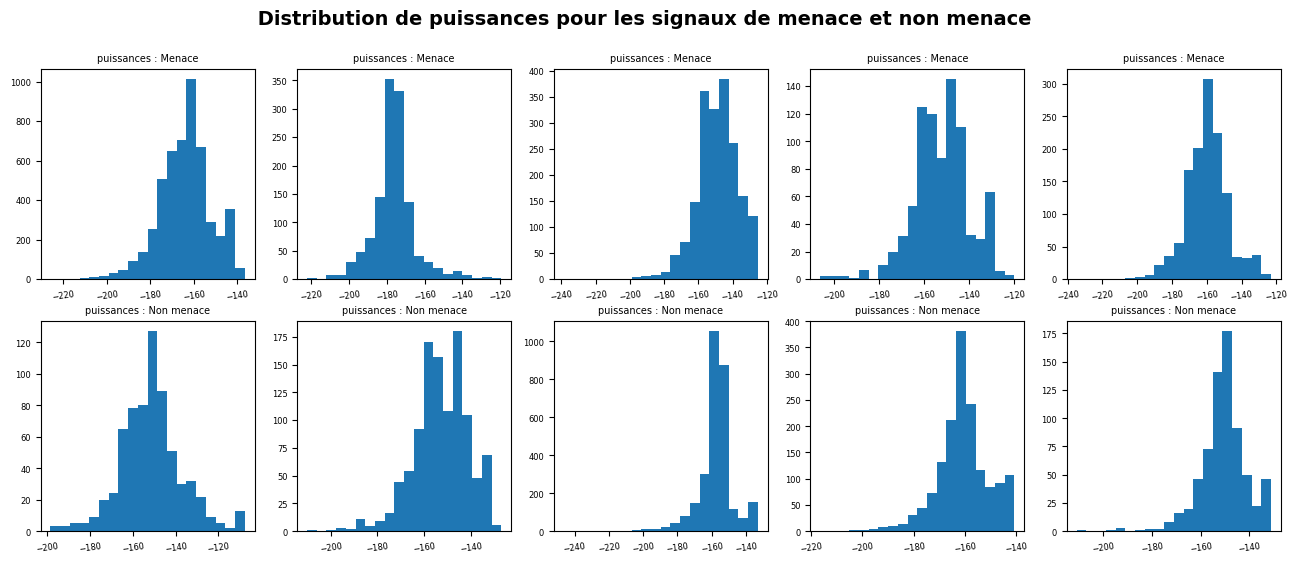

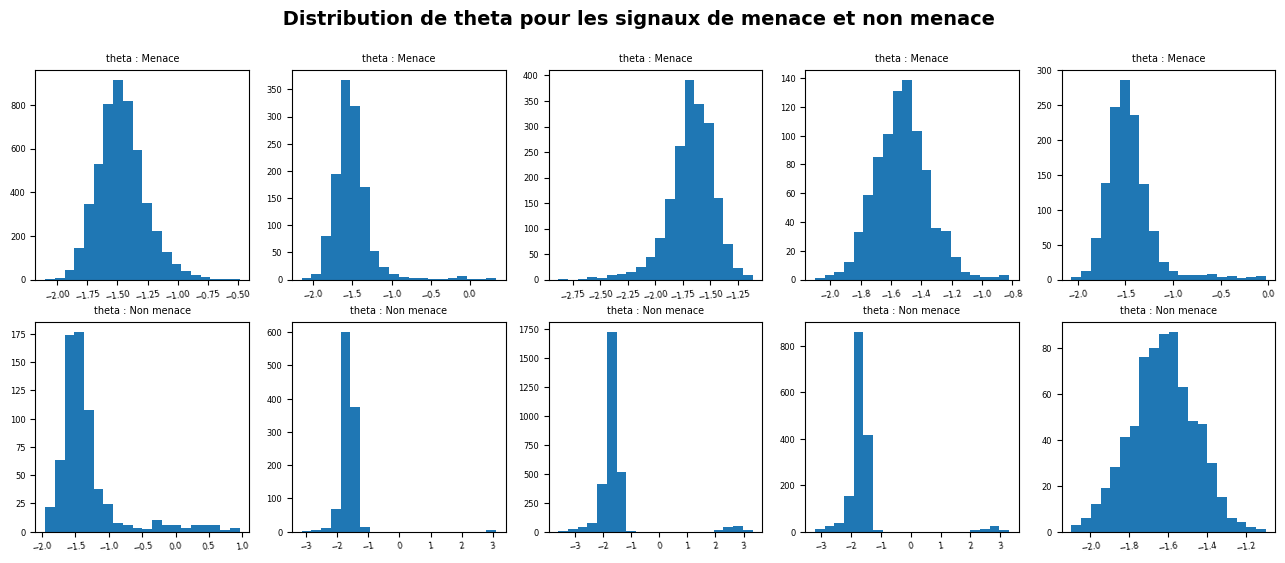

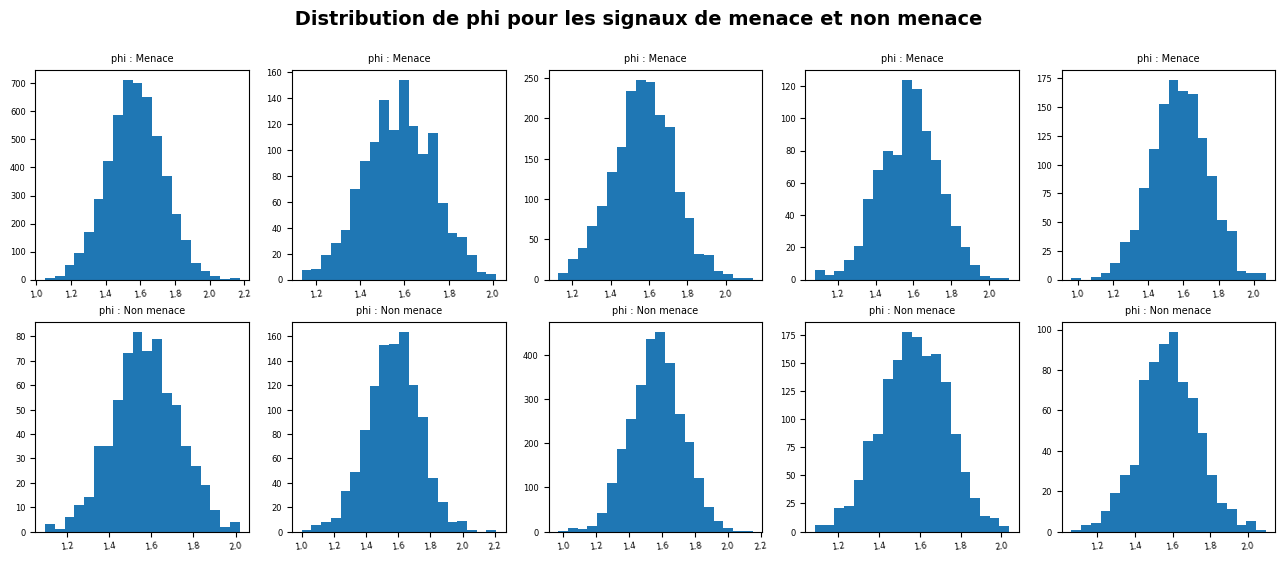

In [10]:
# Visualiser la distribution de fréquence pour certains signaux avec une cible différente
menace = []
non_menace = []

for key, value in train_labels.items() :
        if value == 1:
            menace.append(key)
        else :
            non_menace.append(key)

for  var in train_signals["pdw-0"].columns.drop(['dates']) : 
    fig, ax = plt.subplots(2,5)
    fig.set_figwidth(16)
    fig.set_figheight(6)
    fig.suptitle(f" Distribution de {var} pour les signaux de menace et non menace", fontsize=14, fontweight='bold')
    for i, key in enumerate(menace[0:5]) : 
        ax[0, i].hist(train_signals[key][var], bins=20)
        # set title 
        ax[0, i].set_title(f"{var} : Menace")
        #set text size 
        ax[0, i].tick_params(axis='both', which='major', labelsize=6)
        #set title size 
        ax[0, i].title.set_size(7)
        #rotate x axis labels 
        ax[0, i].tick_params(axis='x', rotation=8)
    # subplot title 

    for i, key in enumerate(non_menace[0:5]) : 
        ax[1, i].hist(train_signals[key][var], bins=20)
        ax[1, i].set_title(f"{var} : Non menace")
        ax[1, i].tick_params(axis='both', which='major', labelsize=6)
        ax[1, i].title.set_size(7)
        ax[1, i].tick_params(axis='x', rotation=8)

    plt.show()

Remarque 1 :
* On remarque que les signaux représentant une menace ont tendance à avoir des pulsations de fréquence relativement faible contrairemet aux signaux non-menace pour lesquels les fréquences des pulsations semblent plus élevées

### Test d'hypothèse 
On assume que les variables moyennées "largeurs", "fréquence" et "puissance" permettent d'explqiuer notre variables cible. Et pour cela on va élaborer un T-test sur 2 types d'échantillons pour chaque variable (menace et non menace), et on essaie de prouver l'évidence qui affirme cette explication.

In [107]:
# Let's perform a T-test to assess our notice
from scipy.stats import ttest_ind

mean_menace = df_train[df_train["target"] == 1]
mean_non_menace = df_train[df_train["target"] == 0]


for var in mean_menace.columns.drop("target") :
    t, p = ttest_ind(mean_menace[var], mean_non_menace[var])

    # valider le test 
    if p < 0.05 :
        print(f"On rejette l'hypothotèse nulle, et on affirme que les flucuations entre les deux échanillons sont considérables et dans ce cas on constate que la variable **{var}** explique bien le type du signal (menace ou pas)")
    else : 
        print(f"On accepte l'hypothotèse nulle, et on affirme que les flucuations entre les deux échanillons sont négligeables et dans ce cas on constate que la variable **{var}** n'explique pas bien le type du signal (menace ou pas)")

On rejette l'hypothotèse nulle, et on affirme que les flucuations entre les deux échanillons sont considérables et dans ce cas on constate que la variable **largeurs** explique bien le type du signal (menace ou pas)
On rejette l'hypothotèse nulle, et on affirme que les flucuations entre les deux échanillons sont considérables et dans ce cas on constate que la variable **frequences** explique bien le type du signal (menace ou pas)
On rejette l'hypothotèse nulle, et on affirme que les flucuations entre les deux échanillons sont considérables et dans ce cas on constate que la variable **puissances** explique bien le type du signal (menace ou pas)


D'après nos tests, toutes les variables expliquent une difference entre un signal menace ou pas.

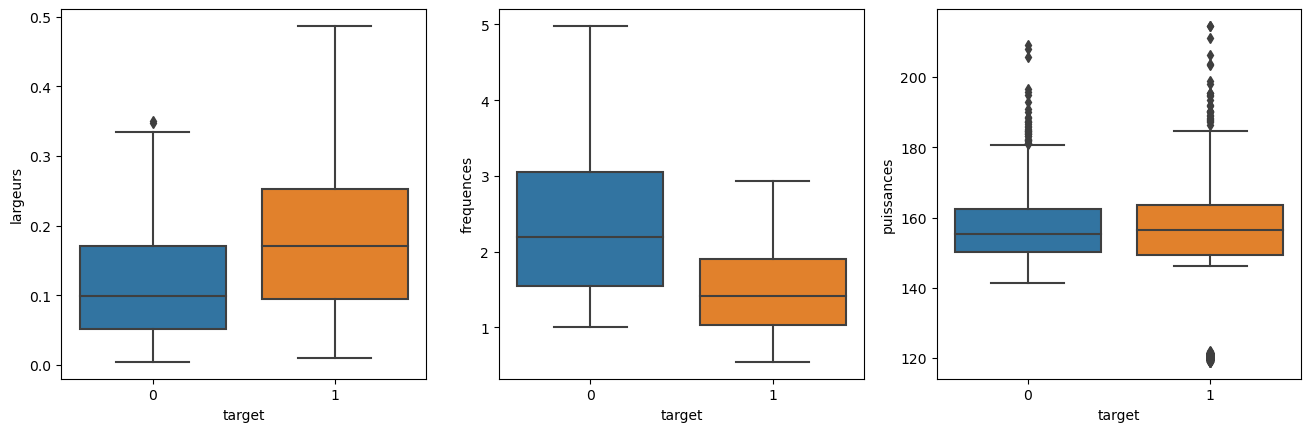

In [12]:
# Show some boxplot 
fig, ax = plt.subplots(1,3)
fig.set_figwidth(16)
for i, var in enumerate(df_train.columns.drop('target')) : 
    sns.boxplot(x="target",y=var, data=df_train, ax=ax[i])

plt.show()

## 2.2. Ajout de nouvelles variables

On repart des objets "signals" et "labels" (train_signals,test_signals, etc) que l'on a créés au début du notebook, et on crée de nouveaux dataframes dans lesquels on collectera progressivement de nouvelles variables. 
Notre analyse exploratoire nous permettra ensuite de sélectionner les variables dérivées les plus pertinentes.

### Création de notre Dataframe pour la selection prograssive de variables

In [18]:
train_data=pd.DataFrame(columns=['signal_ID','label'])
train_data['signal_ID']=train_signals.keys()
train_data['label']=train_labels.values()
train_data.head()

,signal_ID,label
0,pdw-0,0
1,pdw-1,0
2,pdw-10,1
3,pdw-100,0
4,pdw-1000,0


In [47]:
test_data=pd.DataFrame(columns=['signal_ID','label'])
test_data['signal_ID']=test_signals.keys()
test_data['label']=test_labels.values()
test_data.head()

,signal_ID,label
0,pdw-0,1
1,pdw-1,1
2,pdw-10,1
3,pdw-100,0
4,pdw-101,1


In [19]:
interesting_features=[]

### 2.2.a. Features liées au temps d'arrivée des pulsations (dates) "TOA"

In [20]:
#PRI
for signal in train_data.signal_ID:
    dates=train_signals[signal]['dates']
    pri=np.diff(dates)
    train_data.loc[train_data.signal_ID==signal,'PRI_median']=np.median(pri)
    train_data.loc[train_data.signal_ID==signal,'PRI_var']=np.var(pri)
    train_data.loc[train_data.signal_ID==signal,'PRI_iqr']=stats.iqr(pri)
    train_data.loc[train_data.signal_ID==signal,'PRI_mean']=np.mean(pri)
    train_data.loc[train_data.signal_ID==signal,'PRI_max']=np.max(pri)
    train_data.loc[train_data.signal_ID==signal,'PRI_min']=np.min(pri)

In [48]:
#PRI
for signal in test_data.signal_ID:
    dates=test_signals[signal]['dates']
    pri=np.diff(dates)
    test_data.loc[test_data.signal_ID==signal,'PRI_median']=np.median(pri)
    test_data.loc[test_data.signal_ID==signal,'PRI_var']=np.var(pri)
    test_data.loc[test_data.signal_ID==signal,'PRI_iqr']=stats.iqr(pri)
    test_data.loc[test_data.signal_ID==signal,'PRI_mean']=np.mean(pri)
    test_data.loc[test_data.signal_ID==signal,'PRI_max']=np.max(pri)
    test_data.loc[test_data.signal_ID==signal,'PRI_min']=np.min(pri)

### Visualiser les RPI par label

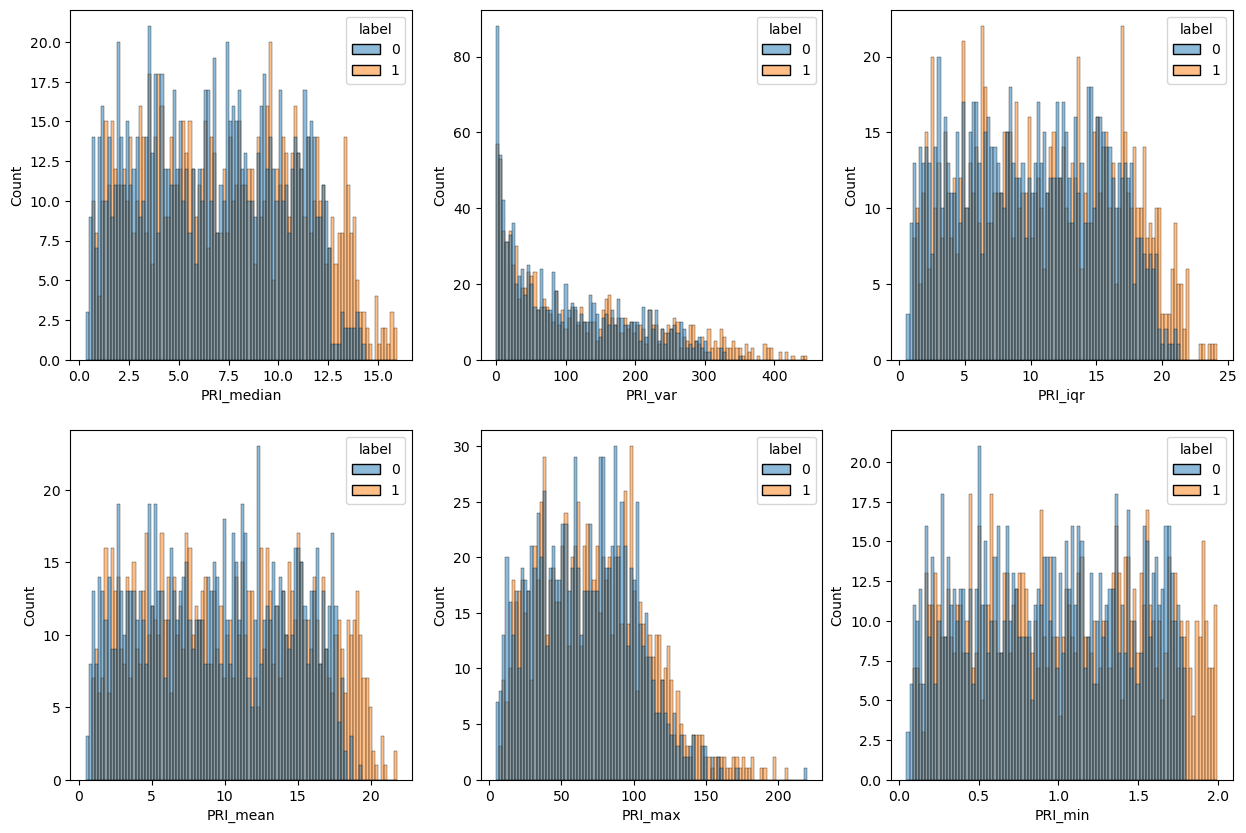

In [26]:
fig, ax = plt.subplots(2, 3, figsize=(15, 10))

for i, var in enumerate(train_data.columns[-6:]):
    row = i // 3
    col = i % 3
    sns.histplot(data=train_data, bins=100, x=var, hue='label', ax=ax[row, col])
    
plt.show()

__Les PRIs très élevés sont associés aux signaux menace__

In [27]:
# On ajoute progressivement les varibales interresente issues de note analyse
interesting_features+=['PRI_mean','PRI_min']

### Fréquence de répétition des impulsions : nombre d’impulsions par unité de temps

In [28]:
for signal in train_data.signal_ID:
    dates=train_signals[signal]['dates']
    bins=int((np.max(dates)-np.min(dates))/1000)
    prf=np.histogram(dates,bins=bins)[0]
    train_data.loc[train_data.signal_ID==signal,'PRF_var']=np.var(prf)
    train_data.loc[train_data.signal_ID==signal,'PRF_iqr']=stats.iqr(prf)
    train_data.loc[train_data.signal_ID==signal,'PRF_mean']=np.mean(prf)
    train_data.loc[train_data.signal_ID==signal,'PRF_max']=np.max(prf)
    train_data.loc[train_data.signal_ID==signal,'PRF_min']=np.min(prf)

In [49]:
for signal in test_data.signal_ID:
    dates=test_signals[signal]['dates']
    bins=int((np.max(dates)-np.min(dates))/1000)
    prf=np.histogram(dates,bins=bins)[0]
    test_data.loc[test_data.signal_ID==signal,'PRF_var']=np.var(prf)
    test_data.loc[test_data.signal_ID==signal,'PRF_iqr']=stats.iqr(prf)
    test_data.loc[test_data.signal_ID==signal,'PRF_mean']=np.mean(prf)
    test_data.loc[test_data.signal_ID==signal,'PRF_max']=np.max(prf)
    test_data.loc[test_data.signal_ID==signal,'PRF_min']=np.min(prf)

### Visualiser les PRF par label

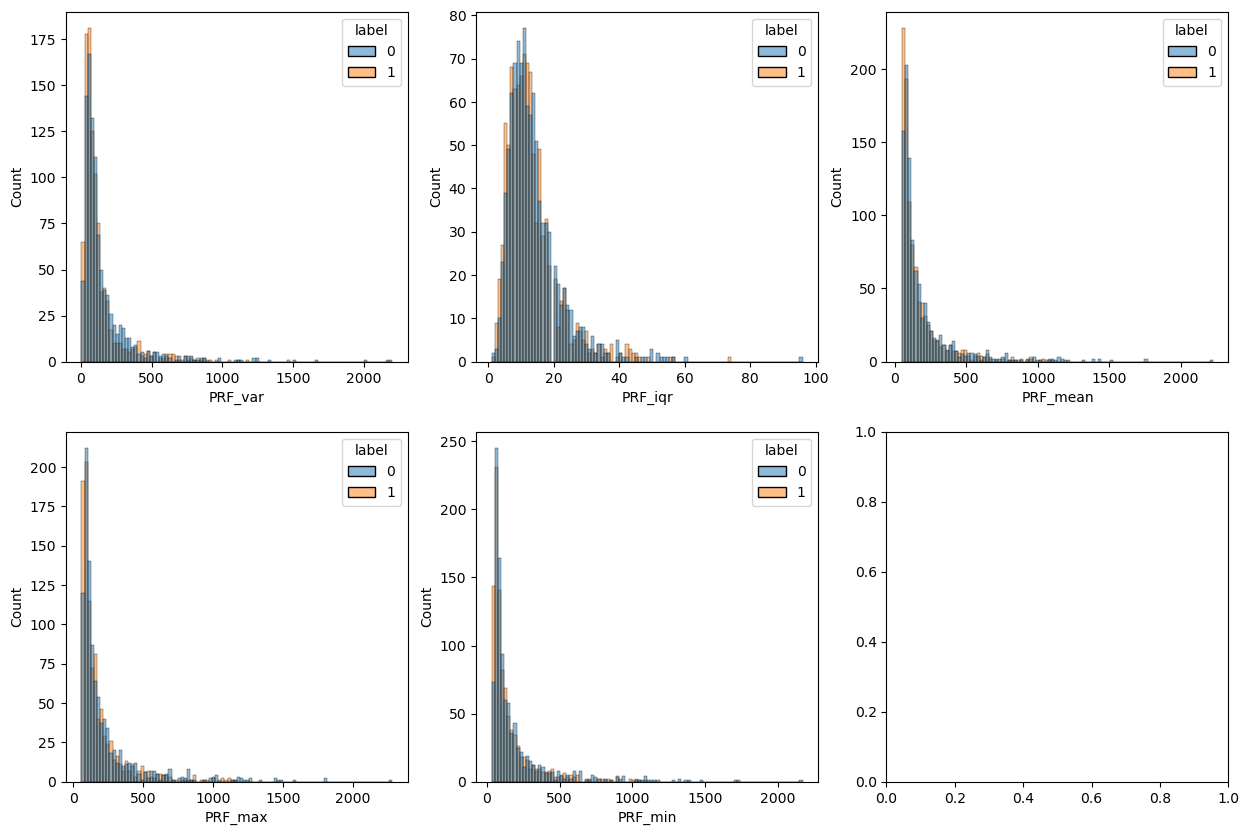

In [29]:
fig, ax = plt.subplots(2, 3, figsize=(15, 10))

for i, var in enumerate(train_data.columns[-5:]):
    row = i // 3
    col = i % 3
    sns.histplot(data=train_data, bins=100, x=var, hue='label', ax=ax[row, col])

plt.show()

__Pas de différence apparente liée aux fréquences de repetition des pulsations__

### 2.2.b. Features liés aux puissances des antennes emettrices

### Scan Analysis : période d’acquisition de l’émetteur (distance entre deux lobes principaux)

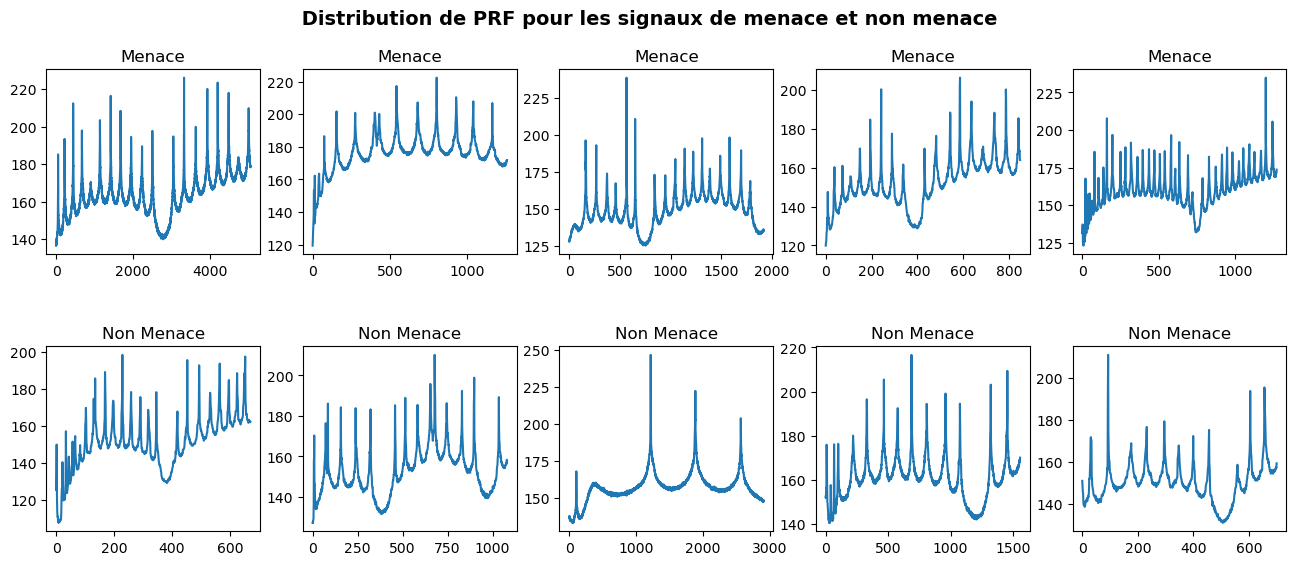

In [33]:
from scipy.signal import hilbert,butter, filtfilt

fig, ax = plt.subplots(2,5)
fig.set_figwidth(16)
fig.set_figheight(6)
fig.subplots_adjust(hspace=0.5)
fig.suptitle(f" Distribution de PRF pour les signaux de menace et non menace", fontsize=14, fontweight='bold')

for i,signal in enumerate(menace[0:5]):
    puissances=train_signals[signal]['puissances']
    ax[0,i].plot(np.abs(puissances))
    ax[0,i].set_title(f"Menace")
for i,signal in enumerate(non_menace[0:5]):    
    puissances=train_signals[signal]['puissances']
    ax[1,i].plot(np.abs(puissances))
    ax[1,i].set_title(f"Non Menace")

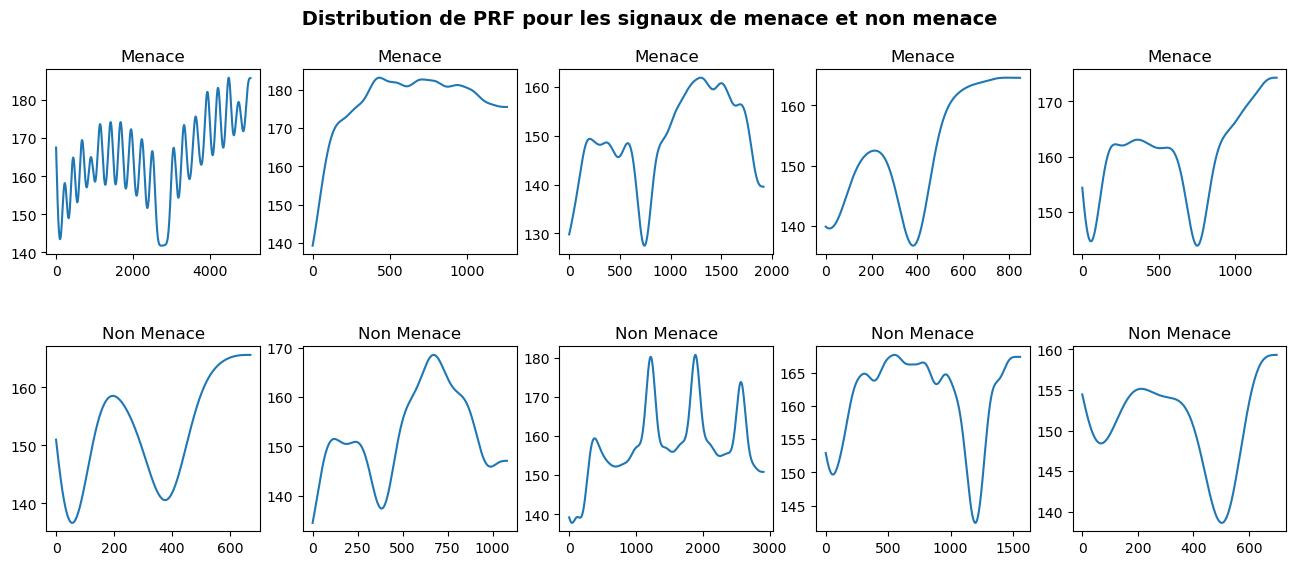

In [35]:
#Scan Analysis : emitter's scan period (distance between two mainlobes)
fig, ax = plt.subplots(2,5)
fig.set_figwidth(16)
fig.set_figheight(6)
fig.subplots_adjust(hspace=0.5)
fig.suptitle(f" Distribution de PRF pour les signaux de menace et non menace", fontsize=14, fontweight='bold')

for i,signal in enumerate(menace[0:5]):

    puissances=train_signals[signal]['puissances']
    analytical_signal = hilbert(puissances)
    envelope = np.abs(analytical_signal)
    b, a = butter(4, 0.01) # The second argument is the cut-off frequency (relative to Nyquist rate)
    # Apply the filter to the envelope
    smoothed_envelope = filtfilt(b, a, envelope)

    ax[0,i].plot(smoothed_envelope)
    ax[0,i].set_title(f"Menace")
for i,signal in enumerate(non_menace[0:5]):  
    
    puissances=train_signals[signal]['puissances']
    analytical_signal = hilbert(puissances)
    envelope = np.abs(analytical_signal)
    b, a = butter(4, 0.01) # The second argument is the cut-off frequency (relative to Nyquist rate)
    # Apply the filter to the envelope
    smoothed_envelope = filtfilt(b, a, envelope)

    ax[1,i].plot(smoothed_envelope)
    ax[1,i].set_title(f"Non Menace")
    

In [38]:
from scipy.signal import argrelextrema

# Let's say y is your array containing the signal values.
def scan_period(puissances):
    analytical_signal = hilbert(puissances)
    envelope = np.abs(analytical_signal)
    b, a = butter(4, 0.01)
    smoothed_envelope = filtfilt(b, a, envelope)
    
    minima_indices = argrelextrema(smoothed_envelope, np.less)
    minima_values = smoothed_envelope[minima_indices]
    
    if len(minima_indices[0]) >= 2:
        # Sort the minima by value and take the first two
        sorted_minima_indices = minima_indices[0][np.argsort(minima_values)]
        # Compute the distance between the two lowest minima
        distance = np.abs(sorted_minima_indices[1] - sorted_minima_indices[0])
    else:
        distance = 0

    return distance

#POWER features
for signal in train_data.signal_ID:
    puissances=train_signals[signal]['puissances']
    train_data.loc[train_data.signal_ID==signal,'power_max']=np.max(puissances)
    train_data.loc[train_data.signal_ID==signal,'power_min']=np.mean(puissances)
    train_data.loc[train_data.signal_ID==signal,'power_scan_period']=scan_period(puissances)

In [50]:
from scipy.signal import argrelextrema

#POWER features
for signal in test_data.signal_ID:
    puissances=test_signals[signal]['puissances']
    test_data.loc[test_data.signal_ID==signal,'power_max']=np.max(puissances)
    test_data.loc[test_data.signal_ID==signal,'power_min']=np.mean(puissances)
    test_data.loc[test_data.signal_ID==signal,'power_scan_period']=scan_period(puissances)

### Distribution des variables statistique dérivées de la puissance

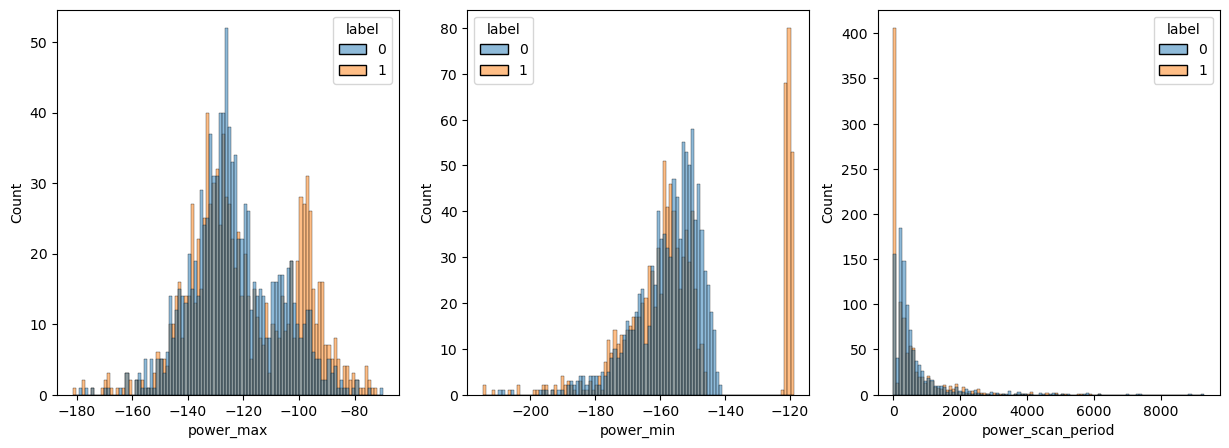

In [45]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

for i, var in enumerate(train_data.columns[-3:]):
    sns.histplot(data=train_data, bins=100, x=var, hue='label', ax=ax[i])

plt.show()

__Pas de différence apparente liée aux variables de puissance__

In [114]:
# Importer tous les signaux au format npz
# chaque signal est un dataframe 2D
import os, json
directory_path = "./radars/train/"
files = os.listdir(directory_path)

with open('./radars/train_labels.json') as f:
    dict_labels = json.load(f)


def temps_arrive(x) : # Moyenner les intervales de temps entre chaque deux implusions d'un signal
    differences =[]
    for i in range(len(x)-1) :
        differences.append(x[i+1] - x[i])
    return np.mean(differences), np.std(differences)

def distance_emetteur(x): # Calcule de la distance de l'emmeteur en se basant sur l'hauteur de l'avion et l'angle phi.
    phi = x*180/ np.pi
    return 10 / np.sin(phi)


# Creae a dataframe that contains all the signals, each signal was shrunk
train_expended = pd.DataFrame()
list = []


for key,value in train_signals.items() :
    signal = value
    list.append({"largeurs_mean" : np.mean(signal["largeurs"]),
                  "largeurs_std" : np.std(signal["largeurs"]) 
                 ,"frequences_mean": np.mean(signal["frequences"]),
                   "frequences_std": np.std(signal["frequences"]) 
                 ,"puissances_mean": np.mean(abs(signal["puissances"])),
                   "puissances_std": np.std(abs(signal["puissances"])) 
                 ,"arrive_mean" : temps_arrive(signal["dates"])[0] 
                    #  "arrive_std" : temps_arrive(signal["dates"])[1]   
                 ,"vitesee_moyenne" : distance_emetteur(np.mean(signal["phi"])) / temps_arrive(signal["dates"])[0] 
                 ,"target":train_labels[key]})

train_expended = pd.DataFrame(list)


In [115]:
test_expended = pd.DataFrame()
list = []
for key,value in test_signals.items() :
    signal = value
    list.append({"largeurs_mean" : np.mean(signal["largeurs"]),
                  "largeurs_std" : np.std(signal["largeurs"]) 
                 ,"frequences_mean": np.mean(signal["frequences"]),
                   "frequences_std": np.std(signal["frequences"]) 
                 ,"puissances_mean": np.mean(abs(signal["puissances"])),
                   "puissances_std": np.std(abs(signal["puissances"])) 
                 ,"arrive_mean" : temps_arrive(signal["dates"])[0] 
                    #  "arrive_std" : temps_arrive(signal["dates"])[1]   
                 ,"vitesee_moyenne" : distance_emetteur(np.mean(signal["phi"])) / temps_arrive(signal["dates"])[0] 
                 ,"target":test_labels[key]})

test_expended = pd.DataFrame(list)


<AxesSubplot:>

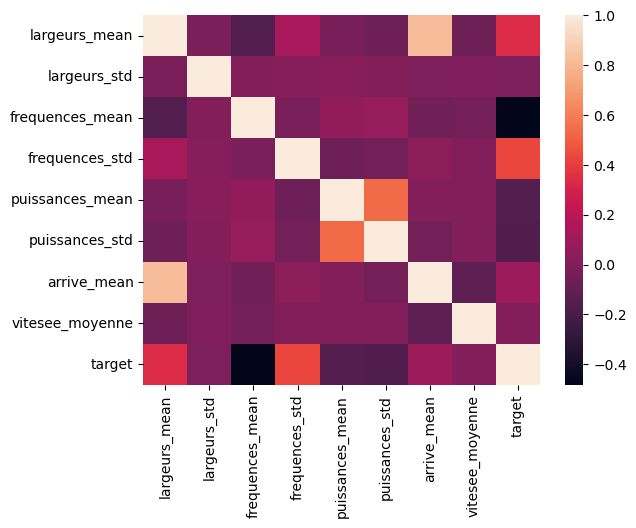

In [116]:
sns.heatmap(train_expended.corr())

### Visualiser les distribution des nouvelles variables dérivés

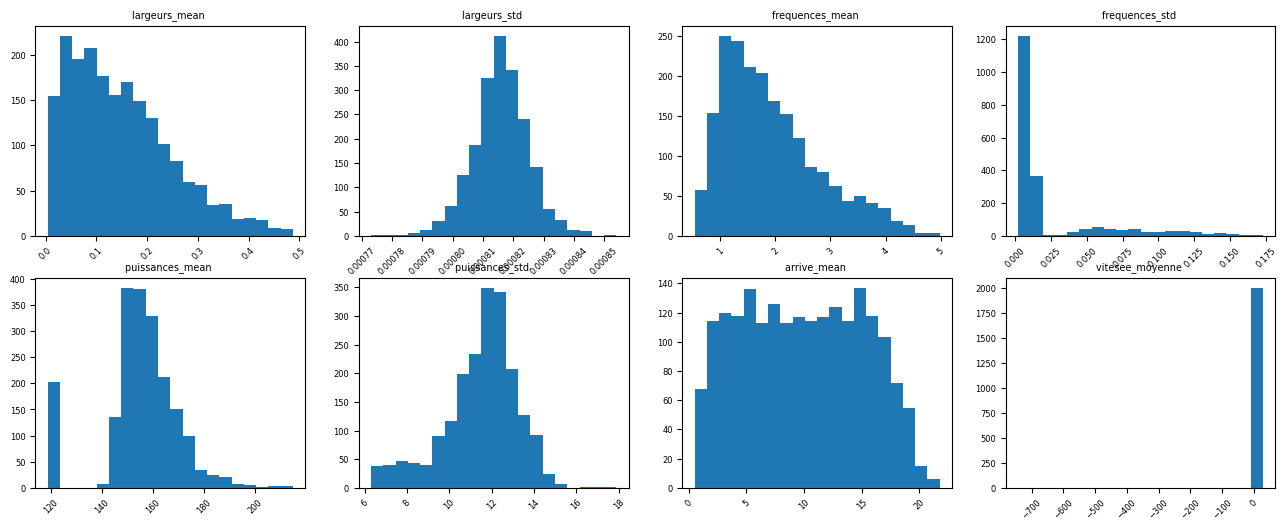

In [118]:
# print distributions 
fig, ax = plt.subplots(2,4)
fig.set_figwidth(16)
fig.set_figheight(6)

for i, var in enumerate(train_expended.columns.drop(['target'])) :
    row = i // 4
    col = i % 4
    ax[row, col].hist(train_expended[var], bins=20)
    # set title 
    ax[row,col].set_title(f"{var} ")
    #set text size 
    ax[row, col].tick_params(axis='both', which='major', labelsize=6)
    #set title size 
    ax[row, col].title.set_size(7)
    #rotate x axis labels 
    ax[row,col].tick_params(axis='x', rotation=45)

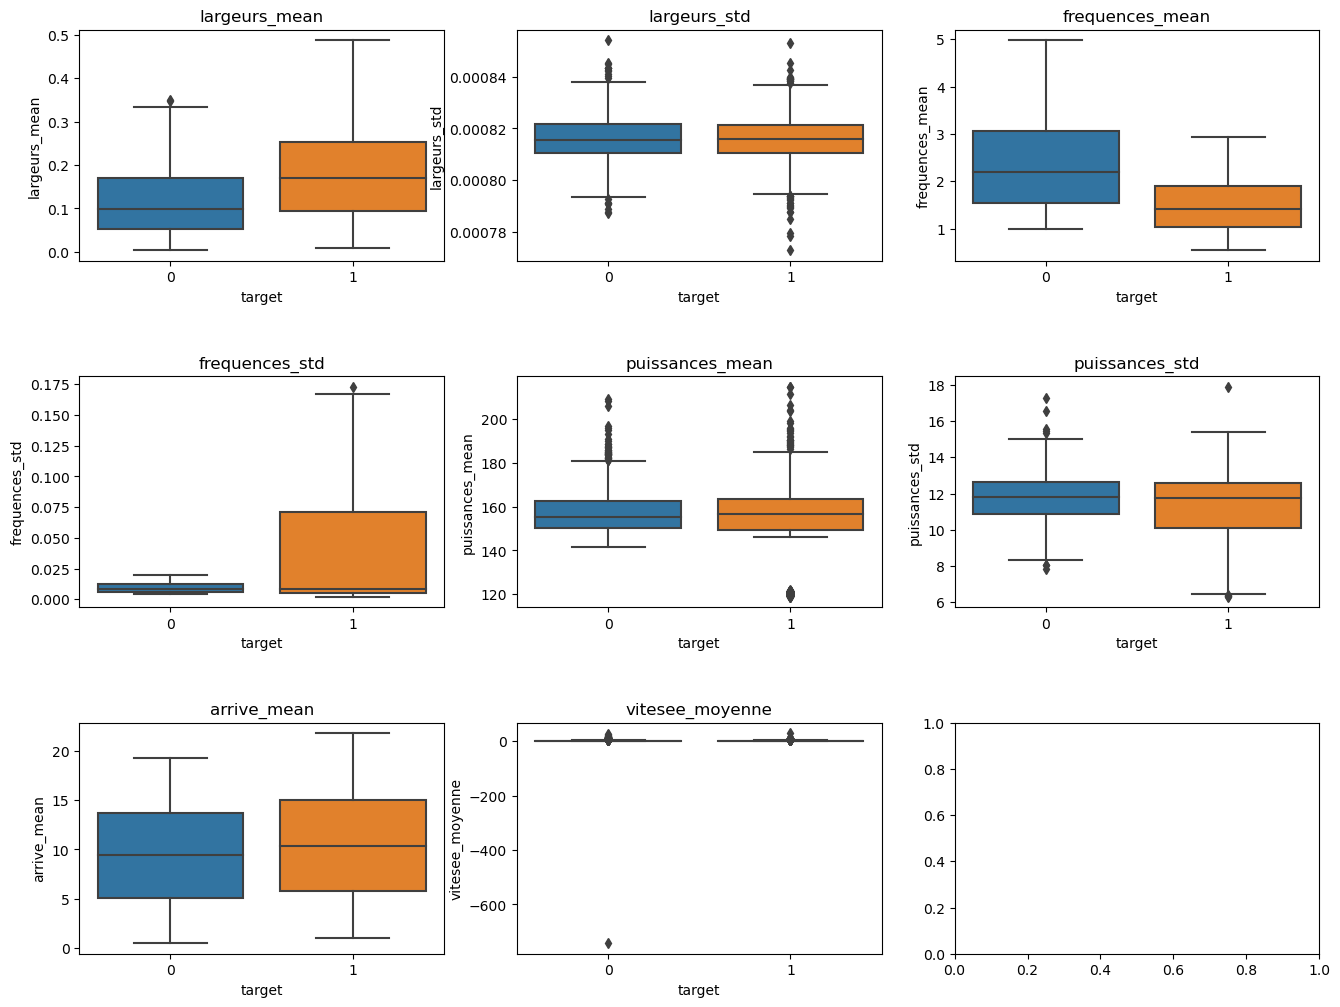

In [120]:
# box plot for all variables based on target 
fig, ax = plt.subplots(3,3)
fig.set_figwidth(16)
fig.set_figheight(12)
fig.subplots_adjust(hspace=0.5)

for i, var in enumerate(train_expended.columns.drop('target')) : 
    row = i // 3
    col = i % 3
    sns.boxplot(x="target",y=var, data=train_expended, ax=ax[row,col])
    ax[row,col].set_title(var)

plt.show()

In [121]:
X_train, X_test, y_train, y_test = train_expended.drop(["target"], axis=1), test_expended.drop(["target"], axis=1), train_expended["target"], test_expended["target"]

In [122]:
X_train = pd.DataFrame(X_train, columns=train_expended.columns.drop("target"))
X_test = pd.DataFrame(X_test, columns=test_expended.columns.drop("target"))

In [105]:
X_train.columns

Index(['largeurs_mean', 'largeurs_std', 'frequences_mean', 'frequences_std',
       'puissances_mean', 'puissances_std', 'vitesee_moyenne', 'PRI_mean',
       'PRF_mean', 'power_min', 'power_scan_period'],
      dtype='object')

### Categoriser les fréquences

In [106]:
# catégoriser les fréquences du train dataset
X_train["frequences_category"] = X_train["frequences_mean"].apply(lambda x : 1 if 0.3 <= x <= 1
                                                   else 2 if 1 < x <= 2 
                                                   else 3 if 2< x <= 3
                                                   else 4 if 3 < x <= 4
                                                   else 5 )
X_train = pd.get_dummies(X_train, columns=["frequences_category"], drop_first=True)

# catégoriser les fréquences du test dataset
X_test["frequences_category"] = X_test["frequences_mean"].apply(lambda x : 1 if 0.3 <= x <= 1
                                                   else 2 if 1 < x <= 2 
                                                   else 3 if 2< x <= 3
                                                   else 4 if 3 < x <= 4
                                                   else 5 )
X_test = pd.get_dummies(X_test, columns=["frequences_category"], drop_first=True)

In [123]:
# Redimensionner les données
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# 2. Entraînement du modèle

In [124]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
# import Xgboost 
import xgboost as xgb

names = [
    "Nearest Neighbors",
    "Linear SVM",
    "RBF SVM",
    "Gaussian Process",
    "Decision Tree",
    "Random Forest",
    "Neural Net",
    "AdaBoost",
    "Naive Bayes",
    "QDA",
]

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025, random_state=42),
    SVC(gamma=2, C=1, random_state=42),
    GaussianProcessClassifier(1.0 * RBF(1.0), random_state=42),
    DecisionTreeClassifier(max_depth=5, random_state=42),
    RandomForestClassifier(
        max_depth=5, n_estimators=10, max_features=1, random_state=42
    ),
    MLPClassifier(alpha=1, max_iter=1000, random_state=42),
    AdaBoostClassifier(random_state=42),
    GaussianNB(),
    QuadraticDiscriminantAnalysis(),
]

# itérer sur les ensembles de données 
for name, clf in zip(names, classifiers):

        
        clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)
        #print the score for each classifier
        print(name," : ", score)


c:\Users\asus\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


Nearest Neighbors  :  0.7925
Linear SVM  :  0.8
RBF SVM  :  0.85125
Gaussian Process  :  0.8475
Decision Tree  :  0.82875
Random Forest  :  0.84
Neural Net  :  0.8225
AdaBoost  :  0.84375
Naive Bayes  :  0.76875
QDA  :  0.8


### Visualition des performance de chaque classifieur

c:\Users\asus\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


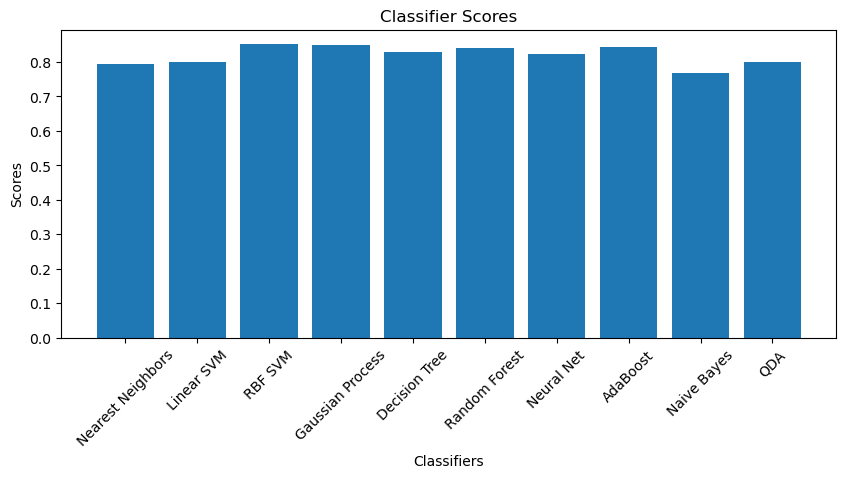

In [134]:
classifier_scores = []
classifiers_names = []

for name, clf in zip(names, classifiers):
    score = clf.score(X_test, y_test)
    classifiers_names.append(name)
    classifier_scores.append(score)

plt.figure(figsize=(10, 4))
plt.bar(classifiers_names, classifier_scores)
plt.xlabel('Classifiers')
plt.ylabel('Scores')
plt.title('Classifier Scores')
plt.xticks(rotation=45)  # Rotate the x-axis labels for readability
plt.show()


### Interpretation
En résumé, le SVM avec noyau RBF a atteint des performances limites de 85%, représentant ainsi le role de nos variables dérivées à transmettre des informations non linéarement séparables, qui ont été résolus par la methode de noyau.
De plus le processus gaussien, AdaBoost et les forêt aléatoire semblent être parmi les meilleurs classificateurs pour ce jeu de données, atteignant des précisions élevées. 


### Entrainer un Xgboost pour differentes tailles d'estimateur et pas d'apprentissages

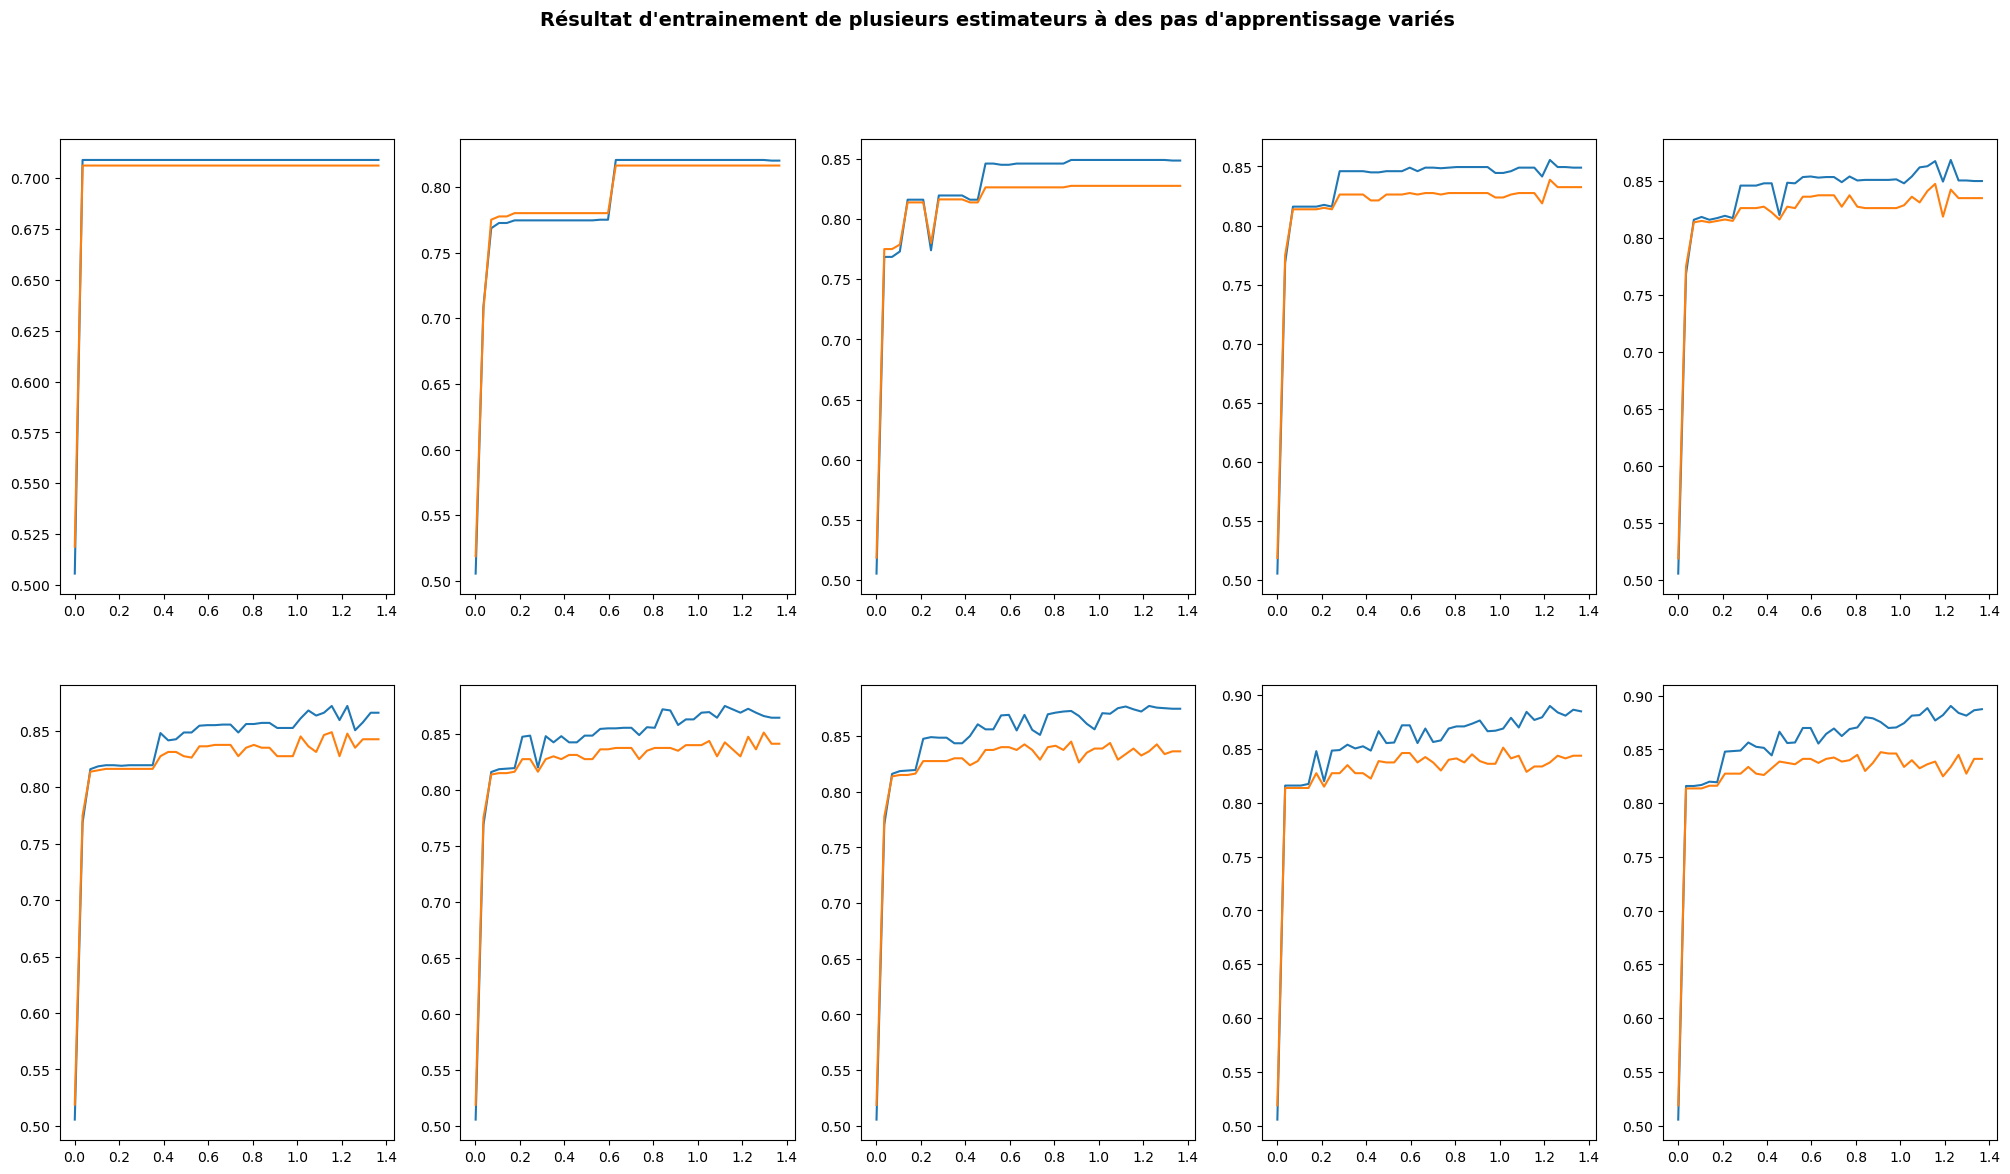

In [136]:
from sklearn.metrics import accuracy_score
# XGBoost (different learning rate)
learning_rate_range = np.arange(0.001, 1.4, 0.035)
test_XG = [] 
train_XG = []
for estimator in range(10) :
 for lr in learning_rate_range:
    xgb_classifier = xgb.XGBClassifier(n_estimators=estimator+1, max_depth=2, learning_rate=lr, objective='binary:logistic')
    xgb_classifier.fit(X_train, y_train)
    train_XG.append(xgb_classifier.score(X_train, y_train))
    test_XG.append(xgb_classifier.score(X_test, y_test))

# plot performances
fig, ax = plt.subplots(2, 5)
fig.set_figwidth(25)
fig.set_figheight(13)
fig.suptitle(f"Résultat d'entrainement de plusieurs estimateurs à des pas d'apprentissage variés", fontsize=14, fontweight='bold')
for i in range(10) :
    row = i // 5  # calculate the row index
    col = i % 5   # calculate the column index
    ax[row, col].plot(learning_rate_range, train_XG[i*40 : (i+1)*40], label="Training" )
    ax[row, col].plot(learning_rate_range, test_XG[i*40 : (i+1)*40], label="test")


plt.show()

Interpretation : 
1. *Stabilité de chaque estimateur :* Les courbes de précision pour les ensembles d'entraînement (Training) et de test (Test) montrent que les modèles sont relativement stables à travers les différents taux d'apprentissage utilisés. Cette stabilité est indiquée par le fait que les courbes de précision ne présentent pas de fluctuations significatives ou de décroissances abruptes à mesure que le taux d'apprentissage augmente.

2. *Performance optimale :* Pour la plupart des estimateurs, il semble y avoir un pique optimal de taux d'apprentissage où la précision est la plus élevée. Ce point est différent pour chaque estimateur, suggérant que le nombre optimal d'arbres (n_estimators) affecte le taux d'apprentissage optimal.

3. *Overfitting :* Dans certains cas, on observe que la précision de l'entraînement continue d'augmenter avec un taux d'apprentissage plus élevé tandis que la précision de test stagne ou diminue légèrement, ce qui peut indiquer un surajustement du modèle aux données d'entraînement. 

Les performances peuvent être encore améliorées, en élargissant les données d'entrainement, ainsi qu'en repérant d'autres variables exogènes plus parlantes.


<h1 style="text-align : center "> FIN </h1>